<a href="https://colab.research.google.com/github/TahmasbiM/genetic-algorithm-nqueens/blob/master/AI_Mountain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow
import matplotlib.pyplot as plt
import gym
import numpy as np
from tqdm import tqdm, trange
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
# from tensorflow.t import TensorBoard
from datetime import datetime
import glob, os


In [31]:
env = gym.make('MountainCar-v0')
env.seed(1); torch.manual_seed(1); np.random.seed(1)
PATH = glob.glob(os.path.expanduser('~/tboardlogs/'))
writer = summary('~/tboardlogs/{}'.format(datetime.now().strftime('%b%d_%H-%M-%S')))

TypeError: ignored

Furthest Position: -0.14333411888104666


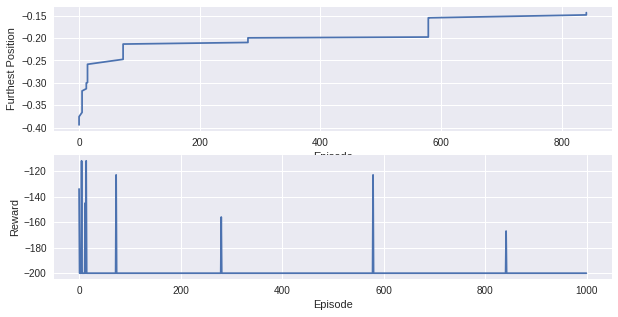

successful episodes: 0


In [18]:
max_position = -.4
positions = np.ndarray([0,2])
rewards = []
successful = []
for episode in range(1000):
    running_reward = 0
    env.reset()
    done = False
    for i in range(200):
        state, reward, done, _ = env.step(np.random.randint(0,3))
        # Give a reward for reaching a new maximum position
        if state[0] > max_position:
            max_position = state[0]
            positions = np.append(positions, [[episode, max_position]], axis=0)
            running_reward += 10
        else:
            running_reward += reward
        if done: 
            if state[0] >= 0.5:
                successful.append(episode)
            rewards.append(running_reward)
            break

print('Furthest Position: {}'.format(max_position))
plt.figure(1, figsize=[10,5])
plt.subplot(211)
plt.plot(positions[:,0], positions[:,1])
plt.xlabel('Episode')
plt.ylabel('Furthest Position')
plt.subplot(212)
plt.plot(rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('successful episodes: {}'.format(np.count_nonzero(successful)))

In [21]:
# I tried different weight initializations but found they did not perform well.
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight, 0, 1)

class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.state_space = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        self.hidden = 200
        self.l1 = nn.Linear(self.state_space, self.hidden, bias=False)
        self.l2 = nn.Linear(self.hidden, self.action_space, bias=False)
    
    def forward(self, x):    
        model = torch.nn.Sequential(
            self.l1,
            self.l2,
        )
        return model(x)

      
      
# Parameters
steps = 2000
state = env.reset()
epsilon = 0.3
gamma = 0.99
loss_history = []
reward_history = []
episodes = 3000
max_position = -0.4
learning_rate = 0.001
successes = 0
position = []

# Initialize Policy
policy = Policy()
loss_fn = nn.MSELoss()
optimizer = optim.SGD(policy.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for episode in trange(episodes):
    episode_loss = 0
    episode_reward = 0
    state = env.reset()

    for s in range(steps):
        # Uncomment to render environment
        #if episode % 100 == 0 and episode > 0:
        #    env.render()
        
        # Get first action value function
        Q = policy(Variable(torch.from_numpy(state).type(torch.FloatTensor)))
        
        # Choose epsilon-greedy action
        if np.random.rand(1) < epsilon:
            action = np.random.randint(0,3)
        else:
            _, action = torch.max(Q, -1)
            action = action.item()
        
        # Step forward and receive next state and reward
        state_1, reward, done, _ = env.step(action)
        
        # Find max Q for t+1 state
        Q1 = policy(Variable(torch.from_numpy(state_1).type(torch.FloatTensor)))
        maxQ1, _ = torch.max(Q1, -1)
        
        # Create target Q value for training the policy
        Q_target = Q.clone()
        Q_target = Variable(Q_target.data)
        Q_target[action] = reward + torch.mul(maxQ1.detach(), gamma)
        
        # Calculate loss
        loss = loss_fn(Q, Q_target)
        
        # Update policy
        policy.zero_grad()
        loss.backward()
        optimizer.step()

        # Record history
        episode_loss += loss.item()
        episode_reward += reward
        # Keep track of max position
        if state_1[0] > max_position:
            max_position = state_1[0]
            writer.add_scalar('data/max_position', max_position, episode)
        
        if done:
            if state_1[0] >= 0.5:
                # On successful epsisodes, adjust the following parameters

                # Adjust epsilon
                epsilon *= .99
                writer.add_scalar('data/epsilon', epsilon, episode)

                # Adjust learning rate
                scheduler.step()
                writer.add_scalar('data/learning_rate', optimizer.param_groups[0]['lr'], episode)

                # Record successful episode
                successes += 1
                writer.add_scalar('data/cumulative_success', successes, episode)
                writer.add_scalar('data/success', 1, episode)
            
            elif state_1[0] < 0.5:
                writer.add_scalar('data/success', 0, episode)
            
            # Record history
            loss_history.append(episode_loss)
            reward_history.append(episode_reward)
            writer.add_scalar('data/episode_loss', episode_loss, episode)
            writer.add_scalar('data/episode_reward', episode_reward, episode)
            weights = np.sum(np.abs(policy.l2.weight.data.numpy()))+np.sum(np.abs(policy.l1.weight.data.numpy()))
            writer.add_scalar('data/weights', weights, episode)
            writer.add_scalar('data/position', state_1[0], episode)
            position.append(state_1[0])

            break
        else:
            state = state_1
            
writer.close()
print('successful episodes: {:d} - {:.4f}%'.format(successes, successes/episodes*100))

  0%|          | 0/3000 [00:00<?, ?it/s]


NameError: ignored